In [1]:
# This class tests whether the tensorflow and autograd versions give identical outputs for a simple least squared loss function

In [1]:
from autograd import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sopt.optimizers.autograd.lma import LMA as LMAag
from sopt.optimizers.tensorflow import LMA as LMAtf

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
z_true = np.random.randn(3,10).astype('float32')

random_mat = np.random.randn(3,3)
random_symmetric_mat = random_mat + random_mat.T
evals, evecs = np.linalg.eig(random_symmetric_mat)
affine_transform = evecs

y_true = affine_transform @ z_true
y_true_flat = y_true.flatten()

In [4]:
def y_pred(z_flat):
    z_arr = np.reshape(z_flat, (3, -1))
    return (affine_transform @ z_arr).flatten()

def loss_fn(y):
    return 0.5 * np.sum((y - y_true_flat)**2)

In [5]:
z_guess = np.random.randn(30).astype('float32')

In [6]:
# Testing the autograd implementations

In [7]:
ag_lma1 = LMAag(z_guess, y_pred, loss_fn, squared_loss=True, damping_factor=1., cg_tol=1e-5)
ag_lma2 = LMAag(z_guess, y_pred, loss_fn, squared_loss=False, damping_factor=1., cg_tol=1e-5)

In [8]:
ag_losses1 = []
ag_losses2 = []
for i in range(10):
    out1 = ag_lma1.minimize()
    out2 = ag_lma2.minimize()
    print(i, loss_fn(y_pred(out1)), loss_fn(y_pred(out2)))
    ag_losses1.append(loss_fn(y_pred(out1)))
    ag_losses2.append(loss_fn(y_pred(out2)))

0 6.745080719219516 6.745080719219516
1 1.0792129150751233 1.0792129150751233
2 0.10217400379409441 0.10217400379409441
3 0.005338070402303672 0.005338070402303672
4 0.0001452381786576409 0.0001452381786576409
5 1.966596957955992e-06 1.966596957955992e-06
6 1.2809404387666918e-08 1.2809404387666918e-08
Stopping iteration. Very low loss value: 1.2809404387666918e-08
Stopping iteration. Very low loss value: 1.2809404387666918e-08
7 1.2809404387666918e-08 1.2809404387666918e-08
Stopping iteration. Very low loss value: 1.2809404387666918e-08
Stopping iteration. Very low loss value: 1.2809404387666918e-08
8 1.2809404387666918e-08 1.2809404387666918e-08
Stopping iteration. Very low loss value: 1.2809404387666918e-08
Stopping iteration. Very low loss value: 1.2809404387666918e-08
9 1.2809404387666918e-08 1.2809404387666918e-08


In [9]:
# Tensorflow test

In [15]:
tf.reset_default_graph()
var1 = tf.get_variable('var1', dtype=tf.float32, initializer=z_guess)
var2 = tf.get_variable('var2', dtype=tf.float32, initializer=z_guess)

tf_y_true = tf.convert_to_tensor(y_true_flat, dtype='float32', name='y_true')
tf_affine_transform = tf.convert_to_tensor(affine_transform, dtype='float32', name='affine_transform')

def tf_y_pred(z):
    return tf.reshape(tf_affine_transform @ tf.reshape(z, [3, -1]), [-1])
def tf_loss(y_pred):
    return 0.5 * tf.reduce_sum((tf_y_true - y_pred)**2)
def tf_hessian(y_pred):
    return 1.0

preds1 = tf_y_pred(var1)
preds2 = tf_y_pred(var2)
loss_tensor1 = tf_loss(preds1)
loss_tensor2 = tf_loss(preds2)

tf_lma1 = LMAtf(var1, tf_y_pred, tf_loss, name='opt1', min_cg_tol=1e-1, assert_tolerances=False)
tf_lma2 = LMAtf(var2, tf_y_pred, tf_loss, name='opt2', hessian_fn=tf_hessian, min_cg_tol=1e-1, assert_tolerances=False)

tf_lma1_min = tf_lma1.minimize()
tf_lma2_min = tf_lma2.minimize()
session = tf.Session()
session.run(tf.global_variables_initializer())

In [16]:
tf_losses1 = []
tf_losses2 = []
for i in range(10):
    session.run([tf_lma1_min, tf_lma2_min])
    print(session.run(tf_lma1._mu))
    lossval1, lossval2 = session.run([loss_tensor1, loss_tensor2])
    print(i, lossval1, lossval2)
    tf_losses1.append(lossval1)
    tf_losses2.append(lossval2)
    

6.666667e-05
0 1.45335725e-05 1.45335725e-05
4.4444445e-05
1 2.1378732e-14 2.1378732e-14
4.4444445e-05
2 2.1378732e-14 2.1378732e-14
4.4444445e-05
3 2.1378732e-14 2.1378732e-14
4.4444445e-05
4 2.1378732e-14 2.1378732e-14
4.4444445e-05
5 2.1378732e-14 2.1378732e-14
4.4444445e-05
6 2.1378732e-14 2.1378732e-14
4.4444445e-05
7 2.1378732e-14 2.1378732e-14
4.4444445e-05
8 2.1378732e-14 2.1378732e-14
4.4444445e-05
9 2.1378732e-14 2.1378732e-14


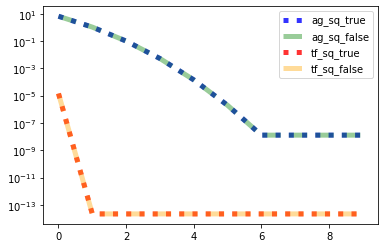

In [14]:
plt.plot(ag_losses1, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='ag_sq_true')
plt.plot(ag_losses2, color='green', ls='--', linewidth=5.0, alpha=0.4, label='ag_sq_false')
plt.plot(np.array(tf_losses1), color='red', ls=':', linewidth=5.0, alpha=0.8, label='tf_sq_true')
plt.plot(np.array(tf_losses2), color='orange', ls='--', linewidth=5.0, alpha=0.4, label='tf_sq_false')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [17]:
session.run(var1)

array([ 0.7632457 ,  0.35943726,  1.534484  , -0.01710471,  1.2816777 ,
        0.39290228,  1.0186828 , -0.5035555 , -0.5358688 , -0.24049735,
       -0.3500105 ,  1.0453898 ,  0.8301344 , -0.63013047,  0.37519586,
        0.29556668,  1.0371232 ,  0.92286104, -0.14413221, -0.61143786,
       -0.7215301 , -0.72698396, -1.0947051 , -1.1066101 ,  1.0241183 ,
        0.9291858 , -0.48584855, -0.15732017, -0.04646305,  1.1199192 ],
      dtype=float32)

In [18]:
z_true

array([[ 0.7632457 ,  0.3594373 ,  1.534484  , -0.01710474,  1.2816777 ,
         0.39290234,  1.0186828 , -0.5035555 , -0.5358688 , -0.24049737],
       [-0.35001054,  1.0453898 ,  0.83013433, -0.63013047,  0.37519586,
         0.29556668,  1.0371231 ,  0.92286104, -0.14413221, -0.61143786],
       [-0.7215301 , -0.726984  , -1.0947051 , -1.1066101 ,  1.0241183 ,
         0.9291859 , -0.48584852, -0.1573202 , -0.04646306,  1.1199192 ]],
      dtype=float32)